In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Polygon, Point
import shapely
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import json
import time as tm

In [2]:
path = '/home/vaschetti/maxarSrc/creating_labels/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)

In [3]:
"""def make_gis_friendly(df):
    df['geometry'] = df['geometry'].apply(shape)
    gdf = gpd.GeoDataFrame(df, crs=4326)
    gdf.to_file(f"{road_df.iloc[0]['country']}_roads.geojson", driver="GeoJSON")

make_gis_friendly(road_df)"""

'def make_gis_friendly(df):\n    df[\'geometry\'] = df[\'geometry\'].apply(shape)\n    gdf = gpd.GeoDataFrame(df, crs=4326)\n    gdf.to_file(f"{road_df.iloc[0][\'country\']}_roads.geojson", driver="GeoJSON")\n\nmake_gis_friendly(road_df)'

In [4]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sample_size = 600
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=600)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs
road_gdf_32628 = road_gdf.to_crs(data_crs)

In [5]:
from shapely.geometry import Polygon, LineString
def rel_road_lines(geodf: gpd.GeoDataFrame,
                    query_bbox_poly: Polygon,
                    res):
    """
    Returns the relative coordinates of a polygon w.r.t. a reference bbox

    Inputs:
        geodf: GeoDataFrame containing the Linestring
        query_bbox_poly: Polygon of the reference bbox
        res: resolution of the image
    Returns:
        result: list of lists of tuples with the relative coordinates
    """
    ref_coords = query_bbox_poly.bounds
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner

    result = []
    for line in geodf.geometry:
        x_s, y_s = line.coords.xy

        rel_x_s = (np.array(x_s) - ref_minx) / res
        rel_y_s = (ref_maxy - np.array(y_s)) / res
        rel_coords = list(zip(rel_x_s, rel_y_s))
        line = LineString(rel_coords)
        result.append(line)
    return result

In [6]:
bg_points = [Point(0,0), Point(0,600), Point(600,600), Point(600,0)]
candidate_points = bg_points
final_points = set(bg_points)
print('candidate_points', candidate_points)
print('final_points', final_points)

final_points.remove(Point(0,0))

print('candidate_points', candidate_points)
print('final_points', final_points)

candidate_points [<POINT (0 0)>, <POINT (0 600)>, <POINT (600 600)>, <POINT (600 0)>]
final_points {<POINT (600 0)>, <POINT (0 600)>, <POINT (0 0)>, <POINT (600 600)>}
candidate_points [<POINT (0 0)>, <POINT (0 600)>, <POINT (600 600)>, <POINT (600 0)>]
final_points {<POINT (600 0)>, <POINT (0 600)>, <POINT (600 600)>}


In [63]:
def plotLinestrings(lines, ax, color = 'red', linewidth = 1):
    
    if not isinstance(lines, list):
        lines = [lines]

    for line in lines:
        x_s, y_s = line.coords.xy
        ax.plot(x_s, y_s, color=color, linewidth=linewidth)

def plotPoints(points, ax, color = 'red', markersize = 5):
    
    if not isinstance(points, list):
        points = [points]

    for point in points:
        x, y = point.xy
        ax.plot(x, y, 'o', color = color, markersize = markersize)

def line2points(line, points_dist):
    """
    Rerurns a list of shapely points along a line
    """
    points = [line.interpolate(dist + points_dist) for dist in np.arange(-points_dist, line.length, points_dist)]
    return points

def line2points2(lines, points_dist):
    """
    Rerurns a list of shapely points along a line
    """
    if not isinstance(lines, list):
        lines = [lines]
    points = []
    for line in lines:
        points.extend([line.interpolate(dist) for dist in np.arange(0, line.length, points_dist)])
    return points

def get_offset_lines(lines, distance=35):
    """
    Create two offset lines from a given line
    """
    if not isinstance(lines, list):
        lines = [lines]
    
    offset_lines = []
    for line in lines:
        for side in [-1, +1]:
            offset_lines.append(line.offset_curve(side*distance ))
    return offset_lines

def clear_roads(lines, bg_points, distance):
    """
    Remove bg points that may be on the road
    """
    candidate_bg_pts = bg_points
    final_bg_pts = set(bg_points)
    
    for line in lines:
        line_space = line.buffer(distance)
        for point in candidate_bg_pts:
            if line_space.contains(point):
                final_bg_pts.discard(point)
        
    return list(final_bg_pts)

def get_pt_at_intesections(lines):
    """
    Returns a list of shapely points at the intersections of the lines
    """
    if not isinstance(lines, list):
        lines = [lines]
    
    intersections = []
    for line in lines:
        for other_line in lines:
            if line == other_line:
                continue
            intersections.append(line.intersection(other_line)) #! occhio ai punti doppi
    return intersections

def rmv_rnd_fraction(points, fraction_to_keep):
    """
    Removes a random fraction of the points
    """
    np.random.shuffle(points)
    points = points[:int(len(points)*fraction_to_keep)]
    return points

In [55]:
import numpy as np

# Create an array
arr = np.array([1, 2, 3, 4, 5])

# Shuffle the array
np.random.shuffle(arr)

# Print the shuffled array
print(arr)

[2 5 4 3 1]


In [58]:
arr[:4]

array([2, 5, 4, 3])

In [30]:
list(bg_pts[0].coords)

[(502.6085197641057, 70.44716867083046)]

In [31]:
np.array([list(pt.coords[0]) for pt in bg_pts]).shape

(131, 2)

In [64]:
a = np.array([1,2,3,4,5,6,7])
rmv_rnd_fraction(a, 0.6)

array([3, 4, 2, 5])

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (318505.859375, 1489843.75)
dx_high:  (318688.96484375, 1490026.85546875)


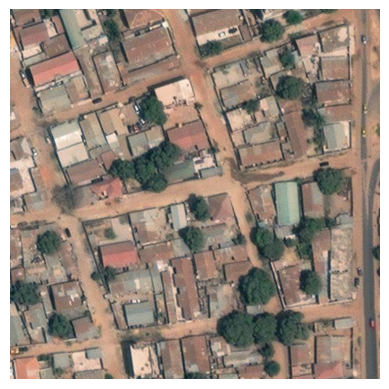

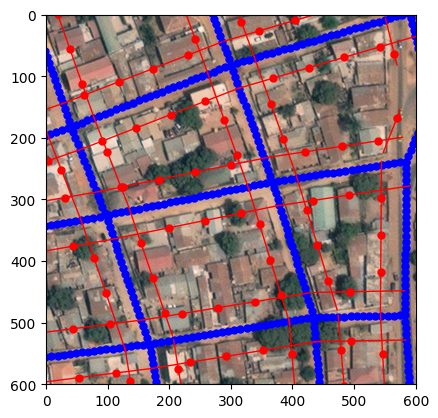

In [96]:
dataset_res = dataset.res

road_point_dist = 10
bg_point_dist = 30
offset_distance = 40

for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    queried_road_gdf_36628 = road_gdf_32628[hits]
    if len(queried_road_gdf_36628) > 20:
        sample = unbind_samples(batch)[0]
        img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

        plt.imshow(img4Sam)
        plt.axis('off')
        plt.savefig('image2.png', bbox_inches='tight', pad_inches=0)

        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)
        road_pts = line2points2(road_lines, road_point_dist)
        
        bg_lines = get_offset_lines(road_lines, offset_distance)
        bg_pts = line2points2(bg_lines, bg_point_dist * 2)

        bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4)

        
        #plotting
        fig, ax2 = dataset.plot(sample) #plot img
        plotLinestrings(road_lines, plt.gca(), color = 'b') #plt road
        plotPoints(road_pts, plt.gca(), color = 'b', markersize = 5)
        plotLinestrings(bg_lines, plt.gca(), color = 'r')
        plotPoints(bg_pts, plt.gca(), color = 'r', markersize = 5)

        np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts])
        #np_roads_pts = rmv_rnd_fraction(np_roads_pts, 0.5)
        np_road_labels = np.array([1]*np_roads_pts.shape[0])

        np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts])
        #np_bg_pts = rmv_rnd_fraction(np_bg_pts, 0.5)
        np_bg_labels = np.array([0]*np_bg_pts.shape[0])

        pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts))
        labels4Sam = np.concatenate((np_road_labels, np_bg_labels))

        
        ax2.set_xlim([0, sample_size])
        ax2.set_ylim([sample_size, 0])
        
        break

In [44]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda')

predictor = SamPredictor(sam)

In [91]:
predictor.set_image(img4Sam)

In [34]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))


def plot_w_wo_masks(img, masks, boxes, pt_coords, pt_labels, only_pred=False, only_masks = False):
    
    if not only_pred:
        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(img)

        ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
        ax2.imshow(img)
        for mask in masks:
            show_mask(mask.cpu().numpy(), ax2)
        if not only_masks:
            for box in boxes:
                show_box(box.cpu().numpy(), ax2)
            for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
                show_points(point.cpu().numpy(), label.cpu().numpy(), ax2)
        
        ax2.set_xlim([0, img.shape[1]])
        ax2.set_ylim([img.shape[0], 0])

        ax1.axis('off')
        ax2.axis('off')
    else:
        fig = plt.figure(figsize=(7, 7))
        plt.imshow(img)

        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca())
        for box in boxes:
            show_box(box.cpu().numpy(), plt.gca())
        for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
            show_points(point.cpu().numpy(), label.cpu().numpy(), plt.gca())
        
        plt.gca().set_xlim([0, img.shape[1]])
        plt.gca().set_ylim([img.shape[0], 0])

        plt.gca().axis('off')

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (318505.859375, 1489843.75)
dx_high:  (318688.96484375, 1490026.85546875)


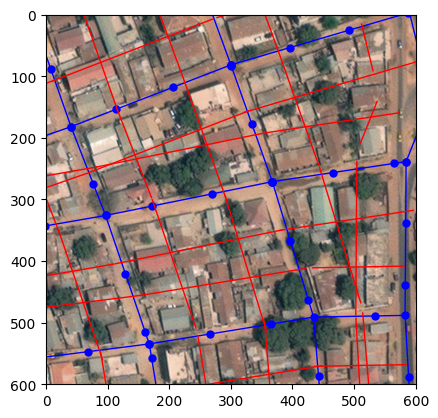

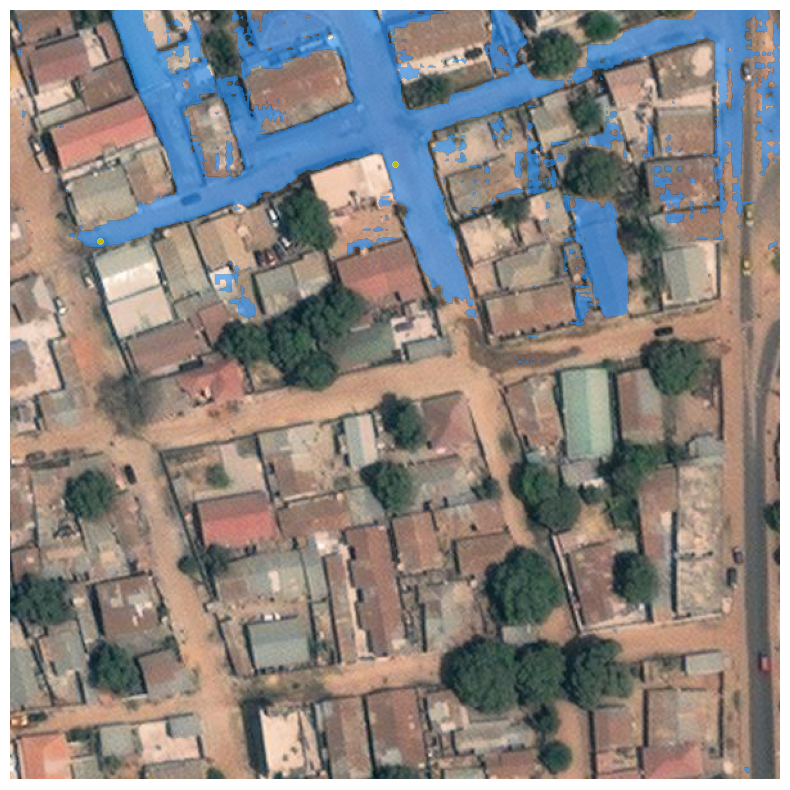

In [109]:
dataset_res = dataset.res

road_point_dist = 100
bg_point_dist = 1060
offset_distance = 80

for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    queried_road_gdf_36628 = road_gdf_32628[hits]
    if len(queried_road_gdf_36628) > 20:
        sample = unbind_samples(batch)[0]
        img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)
        road_pts = line2points2(road_lines, road_point_dist)
        
        bg_lines = get_offset_lines(road_lines, offset_distance)
        bg_pts = line2points2(bg_lines, bg_point_dist * 2)

        bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4)

        
        #plotting
        fig, ax2 = dataset.plot(sample) #plot img
        plotLinestrings(road_lines, plt.gca(), color = 'b') #plt road
        plotPoints(road_pts, plt.gca(), color = 'b', markersize = 5)
        plotLinestrings(bg_lines, plt.gca(), color = 'r')
        plotPoints(bg_pts, plt.gca(), color = 'r', markersize = 5)

        np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts])
        #np_roads_pts = rmv_rnd_fraction(np_roads_pts, 0.5)
        np_road_labels = np.array([1]*np_roads_pts.shape[0])

        np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts])
        #np_bg_pts = rmv_rnd_fraction(np_bg_pts, 0.5)
        np_bg_labels = np.array([0]*np_bg_pts.shape[0])

        pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts))
        labels4Sam = np.concatenate((np_road_labels, np_bg_labels))

        
        ax2.set_xlim([0, sample_size])
        ax2.set_ylim([sample_size, 0])
        
        break


pt_coords4Sam=np.array([[300,120], [70, 180]])
labels4Sam=np.array([1, 1])

masks, _, _ = predictor.predict(
                point_coords=pt_coords4Sam,
                point_labels=labels4Sam,
                multimask_output=False,
            )
#! prova a predirre una strada per volta
plt.figure(figsize=(10,10))
plt.imshow(img4Sam)
show_mask(masks, plt.gca())
show_points(pt_coords4Sam, labels4Sam, plt.gca())
plt.axis('off')
plt.gca().set_xlim([0, sample_size])
plt.gca().set_ylim([sample_size, 0])
plt.show()

In [ ]:
plot_w_wo_masks(img4Sam, masks, building_boxes_t, point_coords, point_labels, only_pred=False, only_masks=True)

In [ ]:
from typing import List

def roads2SamPoints(road_lines: List[LineString], res, points_dist_mt = 2, offset_distance_mt = 2):
    """
    Inputs:
        road_lines: output of the function rel_road_lines
    
    Return:
        a numpy array of shape (n, 2) with the coordinates of the points
        a numpy array of shape (n,) with the label of the points (0 for background, 1 for road)
    """
    for line in road_lines:
        points_dist, offset_distance = points_dist_mt / res, offset_distance_mt / res
        line2points(line, points_dist, offset_distance)
        

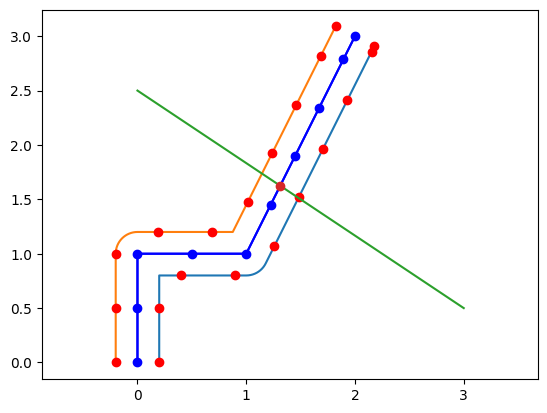

In [81]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Create a LineString and a Point
line = LineString([(0, 0), (0, 1), (1, 1), (2,3)])
length = line.length
part_length = 0.5

#Plot the central line
x, y = line.xy
plt.plot(x, y, color='b')

#Create the points of the central line
points = [line.interpolate(dist + part_length) for dist in np.arange(-part_length, length, part_length)]

# Plot the LineString
x, y = line.xy
plt.plot(x, y, color='b')

# Plot the Point
for point in points:
    x, y = point.xy
    plt.plot(x, y, 'o', color = 'b')

distance = 0.2
for side in [-1, +1]:
    offset = line.offset_curve(side*distance )
    x, y = offset.xy
    plt.plot(x, y)

    points = [offset.interpolate(dist + part_length) for dist in np.arange(-part_length, length, part_length)]
    # Plot the Point
    for point in points:
        x, y = point.xy
        plt.plot(x, y, 'o', color='r')

inters_line = LineString([(3, 0.5), (0, 2.5)])
x, y = inters_line.xy
plt.plot(x, y)

intersection_point = line.intersection(inters_line)

plt.plot(*intersection_point.xy, 'o')

# Display the plot
plt.axis('equal')
plt.show()

In [9]:
from shapely.geometry import LineString

# Assuming 'line' is your LineString
length = line.length
num_parts = 10  # Number of equal parts you want to split the line into

# Calculate the distance of each part
part_length = length / num_parts

# Split the line
parts = [LineString([line.interpolate(dist), line.interpolate(dist + part_length)]) for dist in np.arange(0, length, part_length)]

AttributeError: 'list' object has no attribute 'length'